# Problem 1 (Poisson)

$$-\Delta u = 10$$ for $(x,y) \in \Omega \subset \mathbb{R}^{2}$ and $u = 0$ on $\partial \Omega.$ 
Where $$\Omega = (-1,1)^2 \setminus (0,1) \times (-1,0)$$ in a "L"-shape domain with coordinates and elements as shown in the picture below:

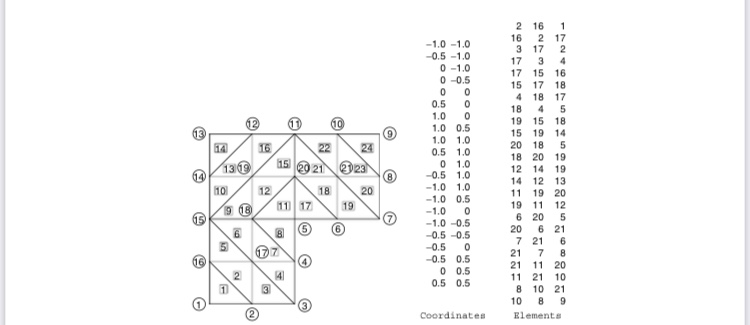

In [32]:
from IPython.display import Image
Image(filename ="/Users/nikosmatsavelas/Desktop/IMG_8369.jpg")

## Load python Finite Element modules

In [33]:
import dmsh
import numpy as np
from skfem import *
from skfem.models.poisson import laplace, unit_load
from skfem import LinearForm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 18})

## Define f(x)

In [34]:
@LinearForm
def f(x, y):
    return(10.0)

## Coordinate array 

In [35]:
coordinates = np.array([
        [-1.0, -1.0],
        [-0.5, -1.0],
        [ 0.0, -1.0],
        [ 0.0, -0.5],
        [ 0.0,  0.0],
        [ 0.5,  0.0],
        [ 1.0,  0.0],
        [ 1.0,  0.5],
        [ 1.0,  1.0],
        [ 0.5,  1.0],
        [ 0.0,  1.0],
        [-0.5,  1.0],
        [-1.0,  1.0],
        [-1.0,  0.5],
        [-1.0,  0.0],
        [-1.0, -0.5],
        [-0.5, -0.5],
        [-0.5,  0.0],
        [-0.5,  0.5],
        [ 0.0,  0.5],
        [ 0.5,  0.5]]);print(coordinates)



[[-1.  -1. ]
 [-0.5 -1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.5  0. ]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]
 [ 0.5  1. ]
 [ 0.   1. ]
 [-0.5  1. ]
 [-1.   1. ]
 [-1.   0.5]
 [-1.   0. ]
 [-1.  -0.5]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [ 0.   0.5]
 [ 0.5  0.5]]


## Element array 

In [36]:
elements = np.array([[2,  16, 1], 
                     [16,  2,17],
                     [3,  17, 2],
                     [17,  3, 4],
                     [17, 15,16],
                     [15, 17,18],
                     [4,  18,17],
                     [18,  4, 5],
                     [19, 15,18], 
                     [15, 19,14],
                     [20, 18, 5],
                     [18, 20,19],
                     [12, 14,19], 
                     [14, 12,13],
                     [11, 19,20],
                     [19, 11,12],
                     [6,  20, 5],
                     [20,  6,21],
                     [7,  21, 6],
                     [21,  7, 8],
                     [21, 11,20],
                     [11, 21,10],
                     [8,  10,21],
                     [10,  8, 9]]);print(elements)

[[ 2 16  1]
 [16  2 17]
 [ 3 17  2]
 [17  3  4]
 [17 15 16]
 [15 17 18]
 [ 4 18 17]
 [18  4  5]
 [19 15 18]
 [15 19 14]
 [20 18  5]
 [18 20 19]
 [12 14 19]
 [14 12 13]
 [11 19 20]
 [19 11 12]
 [ 6 20  5]
 [20  6 21]
 [ 7 21  6]
 [21  7  8]
 [21 11 20]
 [11 21 10]
 [ 8 10 21]
 [10  8  9]]


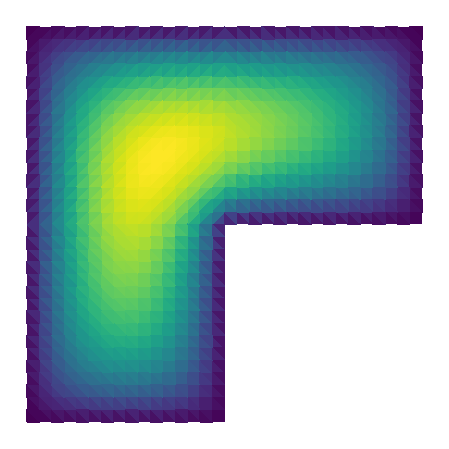

In [37]:
import numpy as np
from skfem import *
from skfem.models.poisson import laplace, unit_load
from skfem import LinearForm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 18})

@LinearForm
def f(x, y):
    return 10.0

m = MeshTri(coordinates.T, elements.T - 1)
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(f, basis)

x = solve(*condense(A, b, I=m.interior_nodes()))

if __name__ == "__main__":
    from os.path import splitext
    from sys import argv
    from skfem.visuals.matplotlib import plot, show
    plot(m, x)
    show()

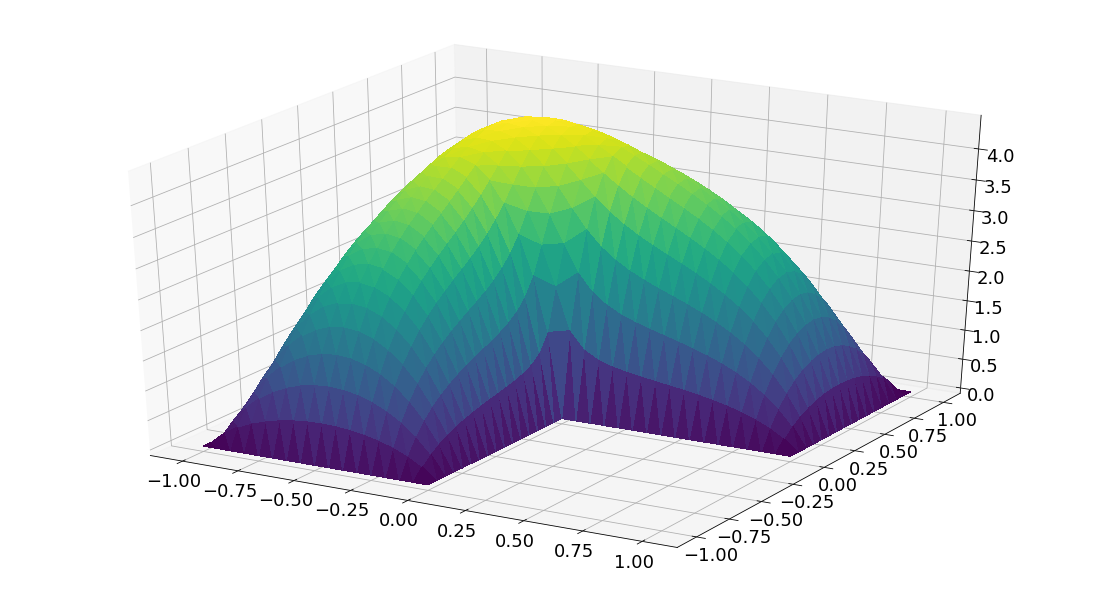

In [38]:
if __name__ == "__main__":
    from os.path import splitext
    from sys import argv
    from skfem.visuals.matplotlib import plot3, show
    plot3(m, x)
    show()

## A posteriori error analysis 


$$\eta_K^2 = h_K^2 \|f\|_{0,K}^2$$
for each element $K$, and

$$\eta_E^2 = h_E \| [[\nabla u_h \cdot n ]] \|_{0,E}^2$$
for each edge $E$.



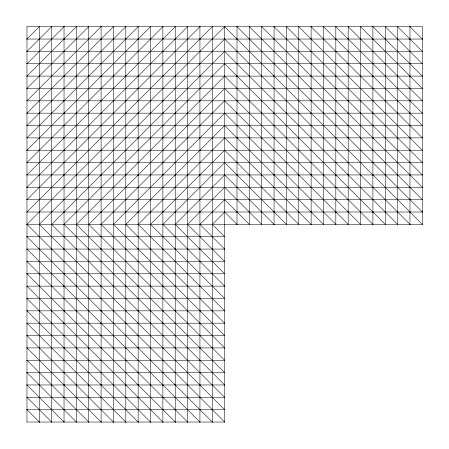

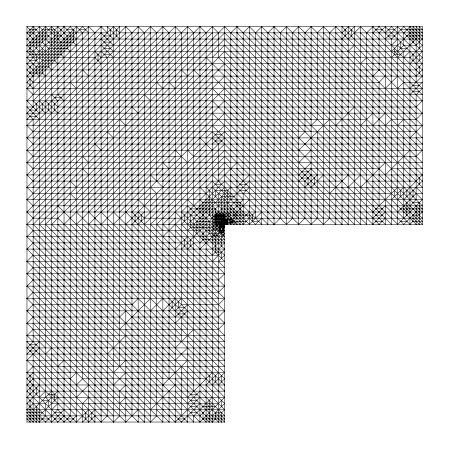

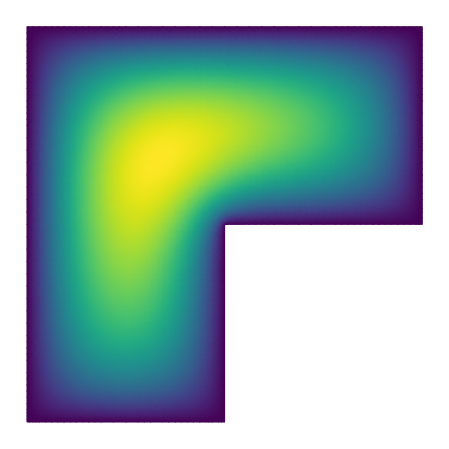

In [39]:
from skfem import *
from skfem.models.poisson import laplace
from skfem.helpers import grad
import numpy as np




def load_func(x, y):
    return 10.0

@LinearForm
def load(v, w):
    x, y = w.x
    return load_func(x, y) * v

def eval_estimator(m, u):    
    # interior residual
    basis = InteriorBasis(m, e)
    
    @Functional
    def interior_residual(w):
        h = w.h
        x, y = w.x
        return h ** 2 * load_func(x, y) ** 2

    eta_K = interior_residual.elemental(basis, w=basis.interpolate(u))
    
    # facet jump
    fbasis = [FacetBasis(m, e, side=i) for i in [0, 1]]   
    w = {'u' + str(i + 1): fbasis[i].interpolate(u) for i in [0, 1]}
    
    @Functional
    def edge_jump(w):
        h = w.h
        n = w.n
        dw1 = grad(w['u1'])
        dw2 = grad(w['u2'])
        return h * ((dw1[0] - dw2[0]) * n[0] +\
                    (dw1[1] - dw2[1]) * n[1]) ** 2

    eta_E = edge_jump.elemental(fbasis[0], **w)
    
    tmp = np.zeros(m.facets.shape[1])
    np.add.at(tmp, fbasis[0].find, eta_E)
    eta_E = np.sum(0.5*tmp[m.t2f], axis=0)
    
    return eta_K + eta_E

if __name__ == "__main__":
    from skfem.visuals.matplotlib import draw, plot, show
    draw(m)

for itr in range(9): # 9 adaptive refinements
    if itr > 0:
        m.refine(adaptive_theta(eval_estimator(m, u)))
        
    basis = InteriorBasis(m, e)
    
    K = asm(laplace, basis)
    f = asm(load, basis)
    
    I = m.interior_nodes()
    u = solve(*condense(K, f, I=I))

if __name__ == "__main__":
    draw(m)
    plot(m, u, shading='gouraud')
    show()

# Problem 2 (Diffusion)

$$u_{t}-\Delta u = 10$$ for $$(t,x,y) \in (0,1) \times \Omega \subset \mathbb{R}^{2}$$ and $u = 0$ on $(0,1) \times \partial \Omega.$ 


Where:

$$\Omega = (-1,1)^2 \setminus (0,1) \times (-1,0)$$ in a "L"-shape domain same as the previous problem.

dt = 0.01 µs


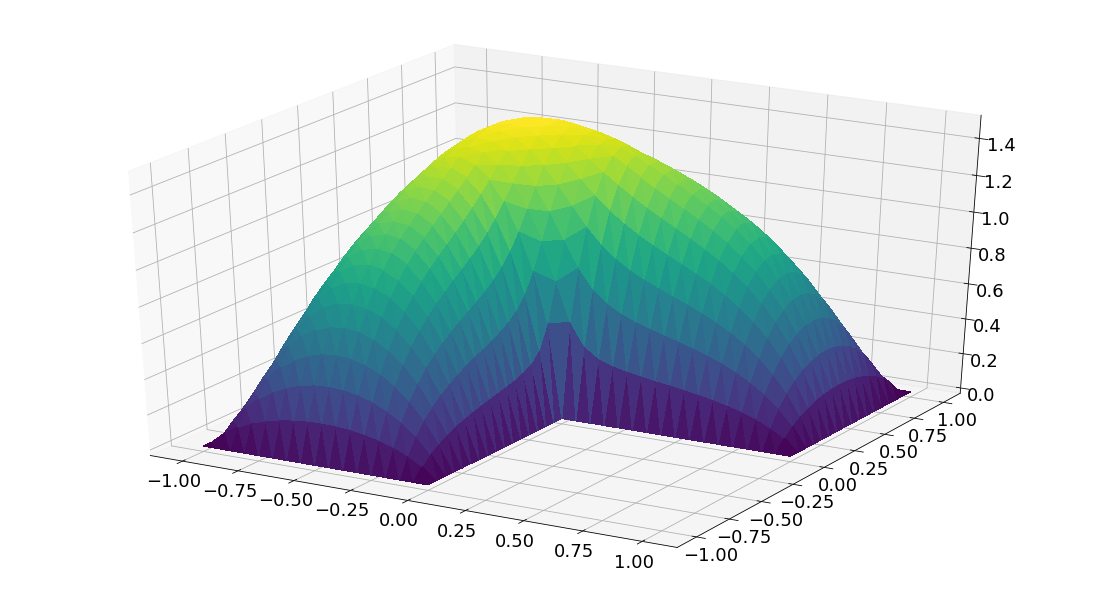

In [53]:
from math import ceil
from typing import Iterator, Tuple

import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import splu

from skfem import *
from skfem.models.poisson import laplace, mass


diffusivity = 1.


m = MeshTri(coordinates.T, elements.T - 1)
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)



L = diffusivity * asm(laplace, basis)
M = asm(mass, basis)

dt = .01
print(f'dt = {dt} µs')
theta = 0.5                     # Crank–Nicolson
A = M + theta * L * dt
B = M - (1 - theta) * L * dt

boundary = basis.find_dofs()
interior = basis.complement_dofs(boundary)

# transpose as splu prefers CSC
backsolve = splu(condense(A, D=boundary, expand=False).T).solve

u_init = 10


def step(t: float,
         u: np.ndarray) -> Tuple[float, np.ndarray]:
    u_new = np.zeros_like(u)               # zero Dirichlet conditions
    _, b1 = condense(csr_matrix(A.shape),  # ignore condensed matrix
                     B @ u, u_new, D=boundary, expand=False)
    u_new[interior] = backsolve(b1)
    return t + dt, u_new


def evolve(t: float,
           u: np.ndarray) -> Iterator[Tuple[float, np.ndarray]]:

    while np.linalg.norm(u, np.inf) > 2**-3:
        t, u = step(t, u)
        yield t, u



if __name__ == "__main__":
    from os.path import splitext
    from sys import argv
    from skfem.visuals.matplotlib import plot3, show
    plot3(m, u)
    show()